# Import librairies

In [18]:
from dolfin import*

import os
import glob

import time
import numpy as np
import pickle

from pathlib import Path
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
from CoolProp.CoolProp import PropsSI
import pyproj
from pyproj import Transformer

from Plot_functions import*
from Auxiliary_functions import *
from Auxiliary_class import*

# Initialize folders

In [2]:
# Initialize time
time0 = time.time()

# Initialize folders for results
input_folder = "QUEST/Inputs"
output_folder = "QUEST/Outputs - Diffusion model/"
figures_output = "QUEST/Figures"

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
if not os.path.exists(output_folder + "/p"):
    os.mkdir(output_folder + "/p")
else:
    for fichier in glob.glob(os.path.join(output_folder + "/p", '*')):
        os.remove(fichier)

if not os.path.exists(output_folder + "/h"):
    os.mkdir(output_folder + "/h")
else:
    for fichier in glob.glob(os.path.join(output_folder + "/h", '*')):
        os.remove(fichier)
    
if not os.path.exists(figures_output):
    os.mkdir(figures_output)

# Extract QUEST reservoir data

In [3]:
# Extract Quest data
df_PCS = pd.read_excel(os.path.join(input_folder, 'Quest, LCS, PCS.xlsx'), sheet_name='Pre-Cambrian')

# Convert GPS coordinates in UTM format
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:26712")
transformer = Transformer.from_crs(wgs84, utm)
def convert_to_cartesian(longitude, latitude):
    x, y = transformer.transform(latitude, longitude)
    return x, y
df_PCS['X'], df_PCS['Y'] = zip(*df_PCS.apply(lambda row: convert_to_cartesian(-row['Long'], row['Lat']), axis=1))

# Area Of Interest coordinates
df_AOI = pd.read_csv(os.path.join(input_folder, 'AOI.csv'), sep=';', names=['Long', 'Lat'])
df_AOI['X'], df_AOI['Y'] = zip(*df_AOI.apply(lambda row: convert_to_cartesian(-row['Long'], row['Lat']), axis=1))
AOI = [[df_AOI['X'][ind], df_AOI['Y'][ind]] for ind in df_AOI.index]

x_min = np.min(df_AOI['X']) ; x_max = np.max(df_AOI['X'])
y_min = np.min(df_AOI['Y']) ; y_max = np.max(df_AOI['Y'])
xmin = x_min - 0.1*(x_max-x_min) ; xmax = x_max + 0.1*(x_max-x_min)
ymin = y_min - 0.1*(y_max-y_min) ; ymax = y_max + 0.1*(y_max-y_min)
Outline = [Point(xmin,ymin), Point(xmax,ymin), Point(xmax,ymax), Point(xmin,ymax), Point(xmin,ymin)]
Outline_array = np.array([[point[0], point[1]] for point in Outline])

# Model parameters

In [4]:
# General parameters
Temp = 10 # C # Temperature of the reservoir
Temp += 273.15 # K
p_ref = 2.0*1e7 # Pa # pressure reference (must be close to the pressure engaged in the reservoir)
p_extrem = 2.5*1e7
g = 9.81 # m.s-2
H0 = 47 # m # Thickness of the reservoir

# Depth of the reservoir. We initialize the depth using values of depth at some points.
# The field is then interpolated.
depth_points = []
depth_field = []
for ind in df_PCS.index:
    if xmin<df_PCS['X'][ind]<xmax and ymin<df_PCS['Y'][ind]<ymax:
        depth_points.append([df_PCS['X'][ind], df_PCS['Y'][ind]])
        depth_field.append(df_PCS['Depth_PCS'][ind]+H0)
        # depth_field.append(-1400) # For flat reservoir
depth_points = np.array(depth_points)
depth_field = np.array(depth_field)

# Thickness of the reservoir. Same procedure than depth.
H_points = np.array(depth_points)
H_field = np.array([H0 for ind in range(len(H_points))])

# Reservoir physical parameters : permeability and porosity. Same procedure than thickness.
k0 = 1e-13 # m2
k_points = np.array([[xmin, xmax], [xmax, ymax], [xmin, ymin], [xmax, ymin]])
k_field = np.array([k0, k0, k0, k0])

phi0 = 0.30
phi_points = np.array([[xmin, xmax], [xmax, ymax], [xmin, ymin], [xmax, ymin]])
phi_field = np.array([phi0, phi0, phi0, phi0])

# Rock compressiblity. Has a small impact on results.
cr = 3e-11 # Pa-1

# Gas. Parameters calculated with CoolProp.
rho_g0 = PropsSI('D', 'T', Temp, 'P', p_ref, 'CO2') # kg.m-3 # density of gas
cg = PropsSI('ISOTHERMAL_COMPRESSIBILITY', 'T', Temp, 'P', p_ref, 'CO2') # Pa-1 # gas compressibility
mug0 = PropsSI('V', 'T', Temp, 'P', p_ref, 'CO2') # Pa.s # viscosity of gas
mug1 = PropsSI('V', 'T', Temp, 'P', p_extrem, 'CO2')
cvg = (mug1-mug0)/(p_extrem-p_ref)
krg = 1 # m2 # Relative permeability of gas in gas region
sg = 0.8 # saturation of gas in the gas region
def rho_g(p): return(rho_g0*(1+cg*(p-p_ref))) # Density profile
def mug(p): return(mug0*(1+cvg*(p-p_ref))) # Viscosity profile

# Water. Parameters calculated with CoolProp.
rho_w0 = PropsSI('D', 'T', Temp, 'P', p_ref, 'WATER') # kg.m-3 # density of water
cw = PropsSI('ISOTHERMAL_COMPRESSIBILITY', 'T', Temp, 'P', p_ref, 'WATER') # Pa-1 # water compressibility
muw0 = PropsSI('V', 'T', Temp, 'P', p_ref, 'WATER') # Pa.s # viscosity of water
muw1 = PropsSI('V', 'T', Temp, 'P', p_extrem, 'WATER')
cvw = (muw1-muw0)/(p_extrem-p_ref)
krw = 1 # m2 # Relative permeability of water
def rho_w(p): return(rho_w0*(1+cw*(p-p_ref))) # Density profile
def muw(p): return(muw0*(1+cvw*(p-p_ref))) # Viscosity profile

# Steps parameter
minute = 60 # s
hour = 60*minute
day = 24*hour
year = 365*day

dt = 1*minute
dt_max = 60*day
T_tot = 20*year # Simulation stopped at T_tot (even if the injection scenario is longer)

# Sources

In [5]:
Sources_g = []
# [location, [rates] in kg.s-1, [Times of operation]]
# Total amount of gas stored per year = 1.08 Mt
Rate_per_well = 1.08e9/365/24/3600/3 # convert to kg.s-1 and divide by 3
points_wells = [Point(370705.4800,5997747.3900), Point(367400,6001000), Point(376800,5994400)]
for point in points_wells:
    Sources_g.append([point, [Rate_per_well], [[T_tot/2, T_tot]]])

sigma = 100 # m # source term standard deviation

# Meshgrid and model settings

Number of cells = 5356
121.9437046764368
3333.735283499833


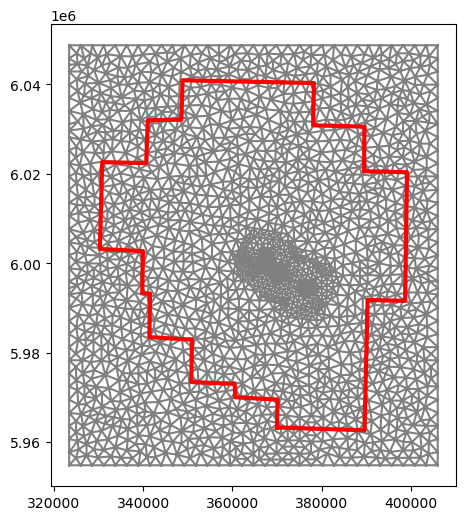

In [6]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
PETScOptions.set("pc_hypre_boomeramg_strong_threshold", .25)
PETScOptions.set("pc_hypre_boomeramg_truncfactor", 0.0)

# Create mesh and build function space
domain = Polygon(Outline)
Nm = 30 # define the global mesh fineness
Nhr = 1 # define the fineness of the mesh around the hydraulic radius of each well
radius1 = 6000 # The meshgrid will be refined Nhr times inside circles of radius=radius1, centered in well locations1
Nst = 3 # define the fineness of the mesh around each source
radius2 = 1000 # The meshgrid will be refined Nhr times inside circles of radius=radius1, centered in well locations1
        # Source term will always be at least as accurate as hydraulic radius. We add Nst degrees of accuracy.

# mesh = create_mesh(domain, Nm, Nhr, Nst, Sources_g, sigma, T_tot, phi0, sg, rho_g0, H0)
mesh = generate_mesh(domain, Nm)
mesh = precise_mesh(mesh, points_wells, Nhr, radius1)
mesh = precise_mesh(mesh, points_wells, Nst, radius2)

print('Number of cells = '+str(mesh.num_cells()))
print(mesh.hmin())
print(mesh.hmax())

P1 = FiniteElement('Lagrange', triangle, 1)
ME = FunctionSpace(mesh, P1*P1)
ME1 = FunctionSpace(mesh, P1)
ME2=VectorFunctionSpace(mesh, "DG", 0)

fig = plt.figure(figsize=(6,6))
# plot_wells(Sources_g) # plot wells (red dots).

plot(mesh)
ax = plt.gca()
plot_AOI(ax, AOI, 'red')
plt.savefig(os.path.join(figures_output, 'QUEST_mesh_reservoir.png'), dpi=300)

# Initial conditions

#### Prepare functions and define initial conditions

In [7]:
# Define trial and test functions
du  = TrialFunction(ME)
v  = TestFunction(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dp, dh = split(du)
p,  h  = split(u)
p0, h0 = split(u0)
v_h, v_p = split(v)

#### Interpolate initial conditions

Removing nan values...


100%|██████████| 2745/2745 [00:00<00:00, 72267.02it/s]

...removed
Interpolating initial conditions...


... interpolated
Injected mass at t = 10.0 days : 0.0 kg.s-1


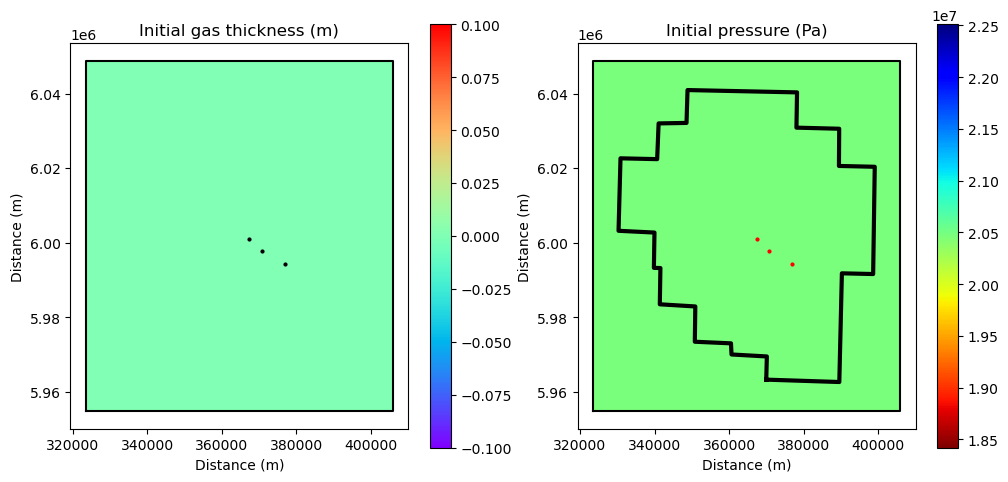

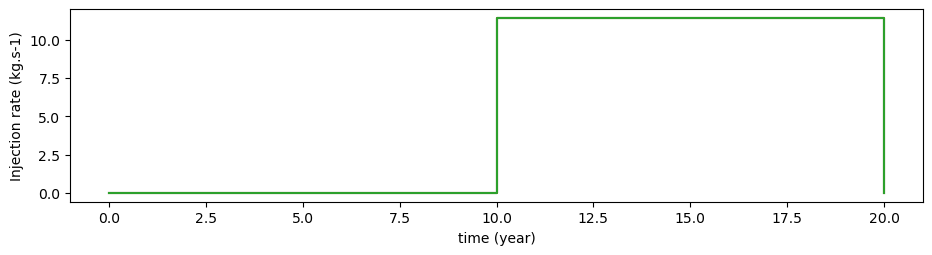

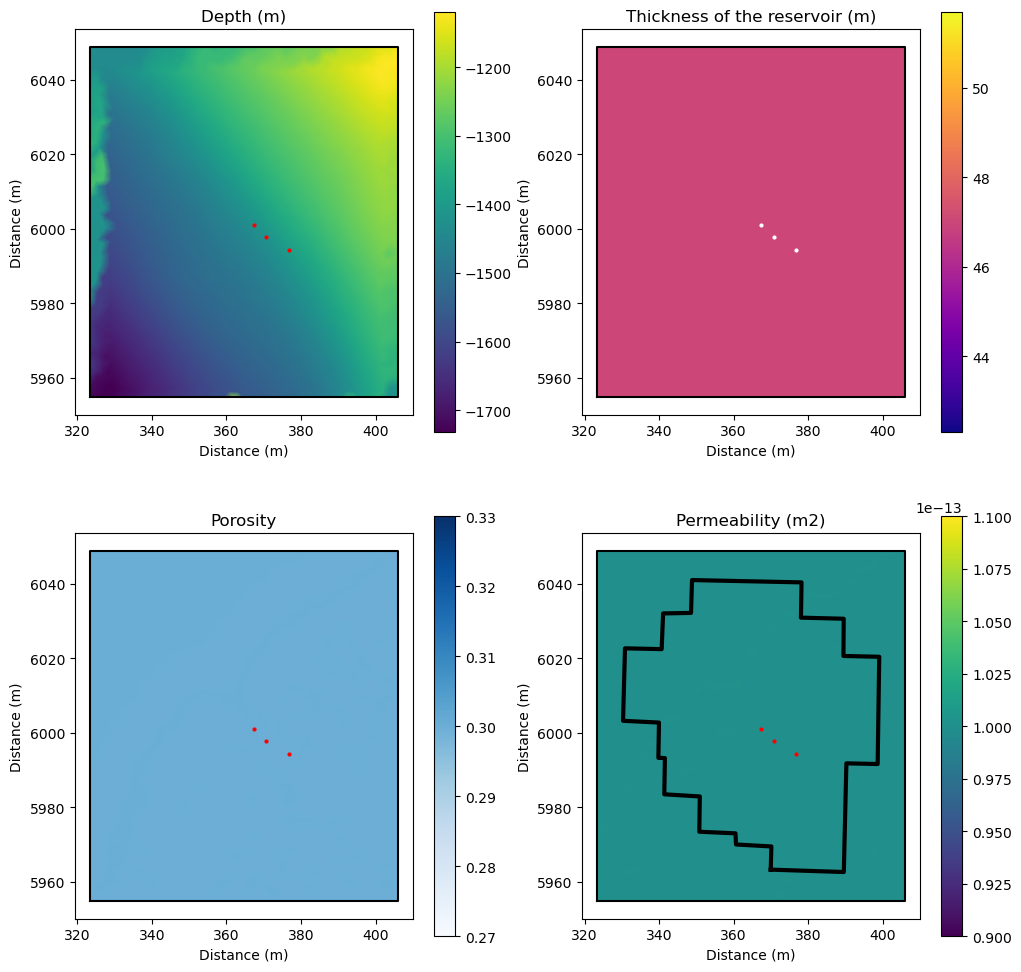

In [8]:
Coords = ME1.tabulate_dof_coordinates() # Coordinates of the mesh

# All the data are interpolated using : Radial basis function interpolation (RBF).
# Initial pressure
p_0 = 204.65e5 # Pa
p_points = np.array([[xmin, ymax], [xmax, ymax],
                     [xmin, ymin], [xmax, ymin]])
p_field = np.array([p_0, p_0,
                    p_0, p_0])
p_init = griddata(p_points, p_field, Coords, method='nearest') # Linear interpolation

# Initial thickness of gas
h_0 = 0 # m
h_points = np.array([[xmin, ymax], [xmax, ymax],
                     [xmin, ymin], [xmax, ymin]])
h_field = np.array([h_0, h_0,
                    h_0, h_0])
h_init = griddata(h_points, h_field, Coords, method='linear')  # Linear interpolation

# Now that we have the mesh, we can interpolate H, phi and k.
H = H_function(H_points, H_field.flatten(), ME1)
k = k_function(k_points, k_field.flatten(), ME1)
phi = phi_function(phi_points, phi_field.flatten(), ME1)
depth = depth_function(depth_points, depth_field.flatten(), ME1)

print('Removing nan values...')
for i in tqdm(range(len(Coords))):
    if np.isnan(H.vector().get_local()[i]): H.vector().get_local()[i] = np.nanmean(Hf.vector().get_local())
    if np.isnan(p_init[i]) and not np.isnan(p_init[i-1]): p_init[i] = p_init[i-1]
    elif np.isnan(p_init[i]): p_init[i] = p_0
    if np.isnan(h_init[i]) : h_init[i] = h_0
print('...removed')

print('Interpolating initial conditions...')
u_init = InitialConditions(p_init, h_init, Coords, ME1)
u.interpolate(u_init)
u0.interpolate(u_init)
print('... interpolated')

# Display real injected mass. This function can be used to verify the amount of the fluid which is injected at a given time.
t_inj = 10*day # Time when we want to verify the injected mass (mass flow rate).
s_g_ = Function(ME1) ; s_g_.interpolate(s(Sources_g, t_inj, ME1, sigma))
print('Injected mass at t = ' + day_format(t_inj) + ' : ' + str(assemble(s_g_*dx)) + ' kg.s-1')

# Plot
plot_initial_conditions(figures_output, Sources_g, u, h_field, Outline_array)
plot_AOI(plt.gca(), AOI, 'black')
plot_extraction_data(figures_output, Sources_g, T_tot)
plot_phi_k_H_depth(figures_output, Sources_g, Outline_array, k, H, phi, depth)
plot_AOI(plt.gca(), AOI, 'black')

# Calculating the topography of the reservoir

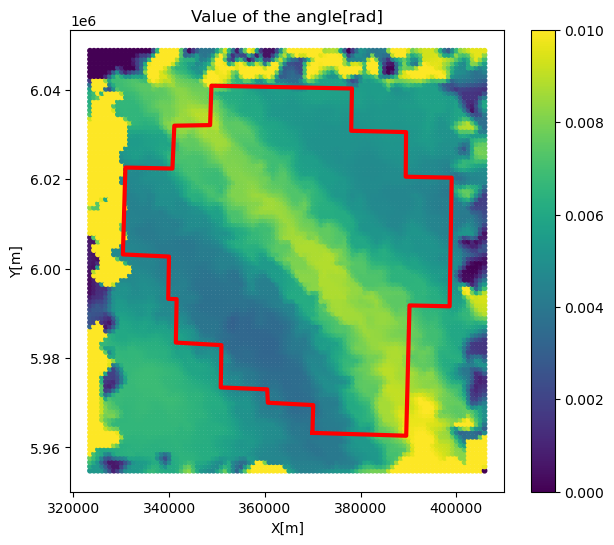

In [9]:
gradi = grad(depth+H)
gradient = project(gradi,ME2) 
gradient_values = gradient.compute_vertex_values(mesh) #to get all the data  from gradient

# Calcul for the gradient in the X direction
gradient_X = []
for i in range(0,int(len(gradient_values)/2)):
    gradient_X.append(gradient_values[i])

# Calcul for the gradient in the Y direction
gradient_Y = []
for i in range(int(len(gradient_values)/2),len(gradient_values)):
    gradient_Y.append(gradient_values[i])

# Creation of a panda fram
panda = pd.DataFrame({'Coord X':mesh.coordinates()[:,0],'Coord Y':mesh.coordinates()[:,1],'Grad X':gradient_X[:],'Grad Y':gradient_Y[:] })

# Calcul of the norme of the gradient
Norme=[]
for i in range(len(panda['Grad Y'])):
    Norme_numpy = math.sqrt(panda['Grad X'][i]**2+panda['Grad Y'][i]**2)
    Norme.append(Norme_numpy)
panda['Norme Gradient']=Norme

# Transposition du gradient; norme(gradient)=angle
angle_Points = np.array(list(zip(panda['Coord X'], panda['Coord Y'])))

x_mesh = np.linspace(xmin, xmax, num=100)  # Vous pouvez ajuster le nombre de points de la grille si nécessaire
y_mesh = np.linspace(ymin, ymax, num=100)
X_mesh, Y_mesh = np.meshgrid(x_mesh, y_mesh)
angle_rad_panda = griddata((panda['Coord X'],panda['Coord Y']),panda['Norme Gradient'], (X_mesh,Y_mesh),method='linear')

# Plot de l'angle
plt.figure(figsize=(7, 6))
plt.scatter(X_mesh,Y_mesh,c=angle_rad_panda, vmin=0, vmax=0.01, s=10)
plt.colorbar()
plt.title('Value of the angle[rad]')
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
angle_value=np.array(panda['Norme Gradient'])
ax = plt.gca()
plot_AOI(ax, AOI, 'red')
angle_points = np.array(list(zip(panda['Coord X'], panda['Coord Y'])))
angle_rad = angle_function(angle_points, angle_value.flatten(), ME1)

# Boundary conditions

In [10]:
use_boundary = False

if use_boundary:
    u_bound = InitialConditions(p_init, h_init, Coords, ME1)

    def boundary_L(x, on_boundary):
        tol = 1000
        if on_boundary:
            for vertice in Outline_array:
                if near(x[0], vertice[0], tol) and near(x[1], vertice[1], tol):
                    return True
        return False

    bc = DirichletBC(ME, u_bound, boundary_L)
    bcs = [bc]
else:
    bcs = []

# Define problem

In [11]:
# Step in time
t = 0.0 # Initialize initial time
Nt = 0 # Initialize number of iterations
List_t = [t] # Create list of step times

problem = define_problem_topography(dt, t,
                                    Sources_g,
                                    ME1,
                                    H, phi, sg, g,
                                    rho_g, rho_w, rho_g0, rho_w0, mug, muw,
                                    cr, cg, cw,
                                    u, p, h, p0, h0, du,
                                    sigma,
                                    v_p, v_h,
                                    k, krg, krw, bcs, depth, angle_rad)

solver = NewtonSolver()
solver.parameters["linear_solver"] = "gmres" # mumps
solver.parameters["convergence_criterion"] = "incremental" # "residual"
solver.parameters["relative_tolerance"] = 1e-8
solver.parameters["absolute_tolerance"] = 1e-7
solver.parameters["maximum_iterations"] = 20

# Main loop (data saved in the main loop)

In [12]:
# Prepare folder to save results
file_p = File (output_folder + "/p" + "/output_p.pvd")
file_h = File (output_folder + "/h" + "/output_h.pvd")
file_p << u.split()[0] ; file_h << u.split()[1]
file_H = File (output_folder + "/H.pvd") ; file_H << H

Mass_found0 = assemble(h*rho_g(p)*phi*dx)*sg # Initial CO2 mass found
List_err = [0] # Create list to save relative difference of CO2 mass (between injected and found)
time0 = time.time() # Save current time to calulate loop duration

while (t < T_tot):
    Nt += 1
    
    print(Fore.BLUE+'Iteration ' + str(Nt) + ' : t = '+day_format(t)+' ------> t = '+day_format(t+dt) + ' (dt = ' + day_format(dt) + ')' )
    print(Style.RESET_ALL)
    t += dt ; List_t.append(t)
    
    u0.vector()[:] = u.vector()[:] # Initialize new value
    (no_of_iterations,converged) = solver.solve(problem, u.vector()) # Solve problem
    Mass_found = assemble(h*rho_g(p)*phi*dx)*sg
    Expected_injected_mass = injected_mass(t, Sources_g)
    if no_of_iterations > 10 : dt /= 16
    elif no_of_iterations > 4 : dt /= 2
    elif dt<dt_max/2 : dt *= 2
    
    # Redefine the problem with new values
    problem = define_problem_topography(dt, t,
                                        Sources_g,
                                        ME1,
                                        H, phi, sg, g,
                                        rho_g, rho_w, rho_g0, rho_w0, mug, muw,
                                        cr, cg, cw,
                                        u, p, h, p0, h0, du,
                                        sigma,
                                        v_p, v_h,
                                        k, krg, krw, bcs, depth, angle_rad)
    
    file_p << u.split()[0]
    file_h << u.split()[1]
    
    print(Fore.GREEN + 'Expected injected mass at t = ' + day_format(t) + " : " + str(Expected_injected_mass*1e-9) + ' Mt')
    print(Fore.GREEN + 'Injected mass found at t = ' + day_format(t) + " : " + str((Mass_found-Mass_found0)*1e-9) + ' Mt (cumulative)')
    if Expected_injected_mass != 0:
        print(Fore.GREEN + 'Relative difference = ' + str(100*abs((Expected_injected_mass-Mass_found+Mass_found0)/Expected_injected_mass)) + ' %')
        List_err.append(abs((Expected_injected_mass-Mass_found+Mass_found0)/Expected_injected_mass))
    else:
        List_err.append(0)

timef = time.time()

Iteration 1 : t = 0 s ------> t = 1 min (dt = 1 min)

Newton iteration 0: r (abs) = 5.389e+02 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 2.932e-03 (tol = 1.000e-07) r (rel) = 5.442e-06 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.057e-08 (tol = 1.000e-07) r (rel) = 1.310e-10 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 13 linear solver iterations.
Expected injected mass at t = 1 min : 0.0 Mt
Injected mass found at t = 1 min : 0.0 Mt (cumulative)
Iteration 2 : t = 1 min ------> t = 3 min (dt = 2 min)

Newton iteration 0: r (abs) = 1.077e+03 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 5.856e-03 (tol = 1.000e-07) r (rel) = 5.435e-06 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.139e-08 (tol = 1.000e-07) r (rel) = 6.626e-11 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 13 linear solver iterations.
Expected injected mass at t = 3 min : 0.0 Mt
Injected mass found at t 

# Loop data

Number of iteration = 176
loop time = 46 s



  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 176/176 [00:03<00:00, 50.17it/s]


Minimum and maximum pressure in the reservoir during operation : 189.9272286887043 / 237.7170443876282 bar
Minimum and maximum value of h during operation : -0.05724044171889497 / 35.9890915495683 m


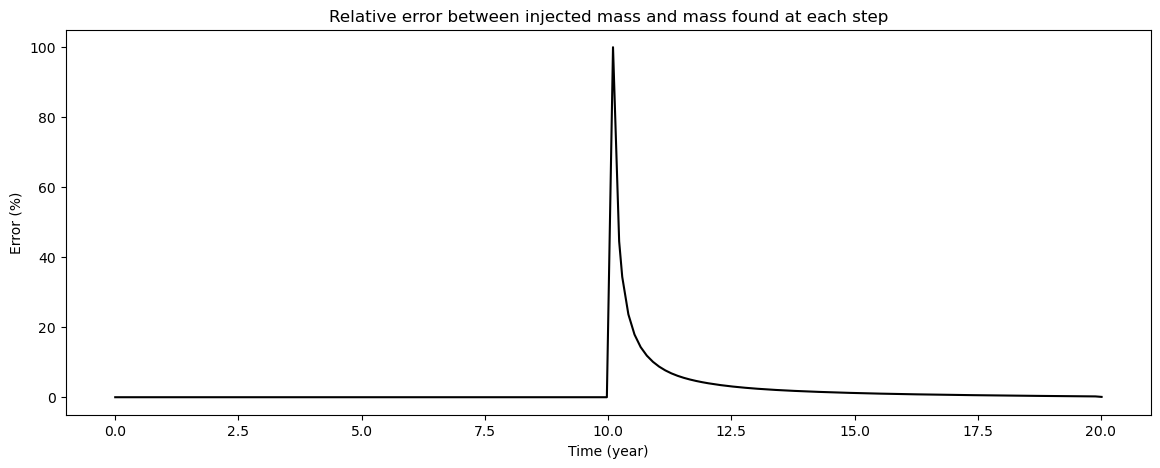

In [13]:

print(Fore.BLUE + 'Number of iteration = ' + str(Nt))
print(Fore.GREEN + 'loop time = ' + day_format(timef - time0))
print(Style.RESET_ALL)

Mass_found = assemble(h*rho_g(p)*phi*dx)*sg # we consider the density as constant
Expected_injected_mass = injected_mass(t, Sources_g)

p_min, p_max, h_min, h_max = min_max_pressure_h_total(output_folder, Nt, H, g, sg, 50, rho_g, rho_w, List_t)

###########################################################################################################################
# Plot loop data
print('Minimum and maximum pressure in the reservoir during operation : ' + str(p_min) + ' / ' + str(p_max) + ' bar')
print('Minimum and maximum value of h during operation : ' + str(h_min) + ' / ' + str(h_max) + ' m')

#Plot relative error (for mass) curve
plt.figure(figsize=(14, 5))
plt.xlabel('Time (year)') ; plt.ylabel('Error (%)')
plt.plot(np.array(List_t)/(24*3600*365), 100*np.array(List_err), color='black')
plt.title('Relative error between injected mass and mass found at each step')
plt.savefig(os.path.join(figures_output, 'QUEST_Model_accuracy.png'), dpi=300, bbox_inches='tight')

# Save and plot results
### Top views

Maximum pressure at the interface at t = 20.01 years : 237.7945260600543 bar
After interpolation : 237.79452606162818 bar
Maximum pressure at the interface at t = 20.01 years : 36.12798988787633 bar
After interpolation : 36.127989864291465 bar
Maximum pressure at the interface at t = 20.01 years : 36.12798988787633 bar
After interpolation : 36.127989864291465 bar


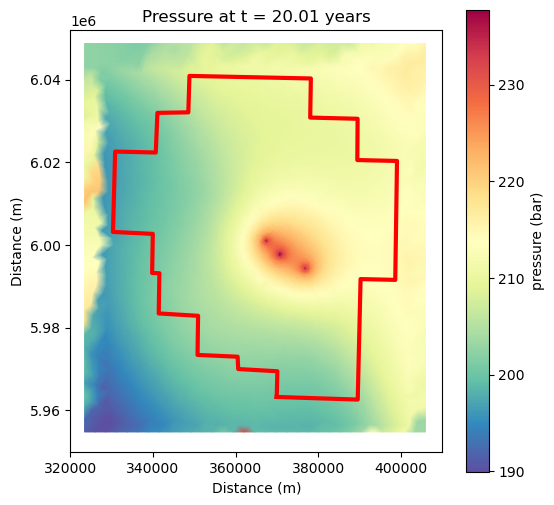

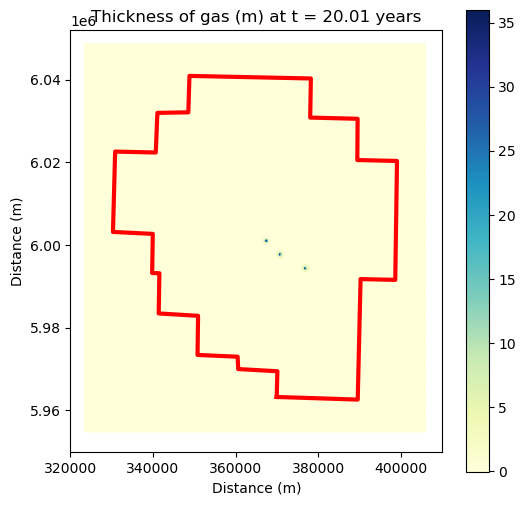

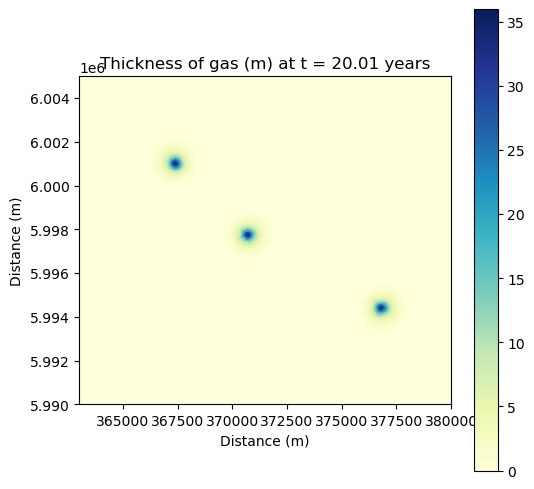

In [17]:
Nx = 1e3 ; Ny = 1e3 ; Nz = 1e3

plot_p(output_folder, figures_output, Nt, AOI, p_min, p_max, List_t, ME1, 320e3, 410e3, 5950e3, 6052e3)
plot_h(output_folder, figures_output, Nt, AOI, h_min, h_max, List_t, ME1, 320e3, 410e3, 5950e3, 6052e3)
plot_h(output_folder, figures_output, Nt, AOI, h_min, h_max, List_t, ME1, 363e3, 380e3, 5990e3, 6005e3)

In [15]:
# export_p(100, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_p(300, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_p(450, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)

# export_h(100, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_h(300, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_h(450, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)

# Export data for mechanical model

In [16]:
# xmax = Outline[1][0]
# xmin = Outline[0][0]
ymax = Outline[2][1]
ymin = Outline[0][1]

XMesh = [] ; YMesh = []
for i in range(54):
    XMesh_tamp = [xmin+(xmax-xmin)*j/49 for j in range(50)]
    XMesh.append(XMesh_tamp)

for i in range(54):
    YMesh_tamp = [ymin+(ymax-ymin)*i/53 for j in range(50)]
    YMesh.append(YMesh_tamp)

X_, Y_ = np.meshgrid(np.array(XMesh)[0], np.array(YMesh)[:,0])
Thick = griddata(H_points, H_field, (X_, Y_), method='linear')
Depth = griddata(depth_points, depth_field, (X_, Y_), method='linear')

# Export RES
dRES = {'Depth':Depth, 'Thickness': Thick}
with open(output_folder + 'RES.p', 'wb') as handle: pickle.dump(dRES, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Export X and Y coordinates
pickle.dump(np.array(XMesh), open(output_folder + 'X.p', 'wb')) ; pickle.dump(np.array(YMesh), open(output_folder + 'Y.p', 'wb'))

# Export Outline
Xcoordinates1 = np.linspace(xmin, xmin, 1000)
Xcoordinates2 = np.linspace(xmin, xmax, 1000)
Xcoordinates3 = np.linspace(xmax, xmax, 1000)
Xcoordinates4 = np.linspace(xmax, xmin, 1000)

Ycoordinates1 = np.linspace(ymin, ymax, 1000)
Ycoordinates2 = np.linspace(ymax, ymax, 1000)
Ycoordinates3 = np.linspace(ymax, ymin, 1000)
Ycoordinates4 = np.linspace(ymin, ymin, 1000)

dOutline = {'X': np.concatenate((Xcoordinates1,Xcoordinates2,Xcoordinates3,Xcoordinates4)), 'Y':np.concatenate((Ycoordinates1,Ycoordinates2,Ycoordinates3,Ycoordinates4))}
dfOutline = pd.DataFrame(data=dOutline)

with open(output_folder + 'Outline.p', 'wb') as handle: pickle.dump(dfOutline, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Export MESH
np.save(output_folder +'MESH.npy', np.array(mesh.coordinates()))

#Export thickness and depth

pickle.dump(np.array(H_points), open(output_folder + 'H_points.npy', 'wb'))
pickle.dump(np.array(H_field), open(output_folder + 'H_field.npy', 'wb'))
pickle.dump(np.array(depth_points), open(output_folder + 'Depth_points.npy', 'wb'))
pickle.dump(np.array(depth_field), open(output_folder + 'Depth_field.npy', 'wb'))
    
# Export data for mechanical model in folder 'output/'
# extract_pressure_list(folder_input, folder_output, Nt)